# Install the Packages

In [ ]:
!pip install yfinance
!pip install https://github.com/matplotlib/mpl_finance/archive/master.zip
!pip install --upgrade mplfinance

# Import the Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import math
import yfinance as yf
import datetime as dt
from matplotlib import dates as mdates
from mplfinance.original_flavor import candlestick_ohlc

In [ ]:
warnings.filterwarnings("ignore")
yf.pdr_override()

# Downloading Data...

In [ ]:
# input
symbol = '^NSEI'
start = dt.date.today() - dt.timedelta(days = 365*5)
end = dt.date.today()

# Read data 
df = yf.download(symbol,start,end)

atr_period = 10
atr_multiplier = 3.0

[*********************100%***********************]  1 of 1 completed


# Super Trend

"A ‘Supertrend’ is overlaid on the price chart and when the indicator slips below the closing price, it generates a buy signal as the colour of the indicator changes into green

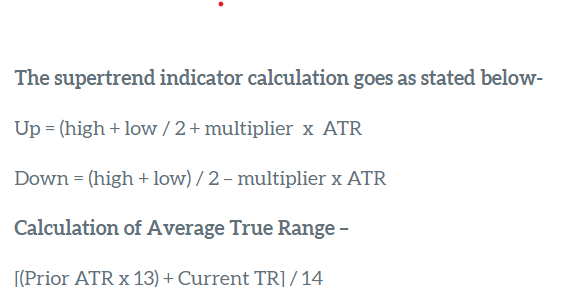

In [ ]:
def Supertrend(df, atr_period, multiplier):
    
    high = df['High']
    low = df['Low']
    close = df['Close']
    
    # calculate ATR
    price_diffs = [high - low, 
                   high - close.shift(), 
                   close.shift() - low]
    true_range = pd.concat(price_diffs, axis=1)
    true_range = true_range.abs().max(axis=1)
    # default ATR calculation in supertrend indicator
    atr = true_range.ewm(alpha=1/atr_period,min_periods=atr_period).mean() 
    # df['atr'] = df['tr'].rolling(atr_period).mean()
    
    # HL2 is simply the average of high and low prices
    hl2 = (high + low) / 2
    # upperband and lowerband calculation
    # notice that final bands are set to be equal to the respective bands
    final_upperband = upperband = hl2 + (multiplier * atr)
    final_lowerband = lowerband = hl2 - (multiplier * atr)
    
    # initialize Supertrend column to True
    supertrend = [True] * len(df)
    
    for i in range(1, len(df.index)):
        curr, prev = i, i-1
        
        # if current close price crosses above upperband
        if close[curr] > final_upperband[prev]:
            supertrend[curr] = True
        # if current close price crosses below lowerband
        elif close[curr] < final_lowerband[prev]:
            supertrend[curr] = False
        # else, the trend continues
        else:
            supertrend[curr] = supertrend[prev]
            
            # adjustment to the final bands
            if supertrend[curr] == True and final_lowerband[curr] < final_lowerband[prev]:
                final_lowerband[curr] = final_lowerband[prev]
            if supertrend[curr] == False and final_upperband[curr] > final_upperband[prev]:
                final_upperband[curr] = final_upperband[prev]

        # to remove bands according to the trend direction
        if supertrend[curr] == True:
            final_upperband[curr] = np.nan
        else:
            final_lowerband[curr] = np.nan
    
    return pd.DataFrame({
        'Supertrend': supertrend,
        'Final Lowerband': final_lowerband,
        'Final Upperband': final_upperband
    }, index=df.index)
    


In [ ]:
supertrend = Supertrend(df, atr_period, atr_multiplier)
df = df.join(supertrend)

In [ ]:
df

,Open,High,Low,Close,Adj Close,Volume,Supertrend,Final Lowerband,Final Upperband
Date,,,,,,,,,
2017-12-21,10473.950195,10473.950195,10426.900391,10440.299805,10440.299805,151900,True,NaN,NaN
2017-12-22,10457.299805,10501.099609,10448.250000,10493.000000,10493.000000,138800,True,NaN,NaN
2017-12-26,10512.299805,10545.450195,10477.950195,10531.500000,10531.500000,155600,True,NaN,NaN
2017-12-27,10531.049805,10552.400391,10469.250000,10490.750000,10490.750000,165200,True,NaN,NaN
2017-12-28,10498.200195,10534.549805,10460.450195,10477.900391,10477.900391,272900,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-12-13,18524.400391,18617.250000,18490.199219,18608.000000,18608.000000,187600,True,18342.715438,NaN
2022-12-14,18671.250000,18696.099609,18632.900391,18660.300781,18660.300781,208000,True,18342.715438,NaN
2022-12-15,18614.400391,18652.900391,18387.699219,18414.900391,18414.900391,183100,True,18342.715438,NaN


# Green or Red?

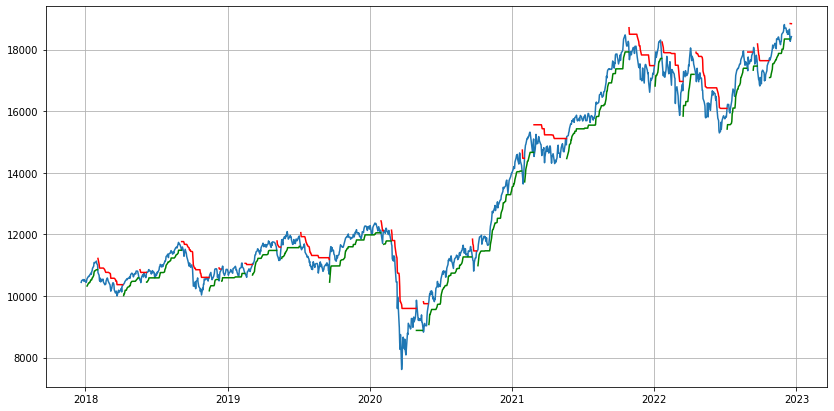

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(df['Close'], label='Close Price')
plt.grid()
plt.plot(df['Final Lowerband'], 'g', label = 'Final Lowerband')
plt.plot(df['Final Upperband'], 'r', label = 'Final Upperband')
plt.show()

# Strategy cum BackTest

The flipping of the indicator over the closing price indicates a signal. A buy signal is indicated in green colour whereas sell signal is given as the indicator turns red. A sell signal occurs when it closes above the price.

In [ ]:
def backtest_supertrend(df, investment):
    is_uptrend = df['Supertrend']
    close = df['Close']
    
    # initial condition
    in_position = False
    equity = investment
    commission = 5
    share = 0
    entry = []
    exit = []
    
    for i in range(2, len(df)):
        # if not in position & price is on uptrend -> buy
        if not in_position and is_uptrend[i]:
            share = math.floor(equity / close[i] / 100) * 100
            equity -= share * close[i]
            entry.append((i, close[i]))
            in_position = True
            print(f'Buy {share} shares at {round(close[i],2)} on {df.index[i].strftime("%Y/%m/%d")}')
        # if in position & price is not on uptrend -> sell
        elif in_position and not is_uptrend[i]:
            equity += share * close[i] - commission
            exit.append((i, close[i]))
            in_position = False
            print(f'Sell at {round(close[i],2)} on {df.index[i].strftime("%Y/%m/%d")}')
    # if still in position -> sell all share 
    if in_position:
        equity += share * close[i] - commission
    
    earning = equity - investment
    roi = round(earning/investment*100,2)
    print(f'Earning from investing Rs.1cr is Rs.{round(earning,2)} (ROI = {roi}%)')
    return entry, exit, equity


# Returns (SuperTrend) 😃

In [ ]:
entry, exit, roi = backtest_supertrend(df, 10000000)

Buy 900 shares at 10531.5 on 2017/12/26
Sell at 10760.6 on 2018/02/02
Buy 900 shares at 10379.35 on 2018/04/09
Sell at 10516.7 on 2018/05/21
Buy 900 shares at 10768.35 on 2018/06/07
Sell at 11476.95 on 2018/09/05
Buy 1000 shares at 10616.7 on 2018/11/15
Sell at 10488.45 on 2018/12/10
Buy 900 shares at 10888.35 on 2018/12/17
Sell at 10724.4 on 2019/02/15
Buy 900 shares at 11053.0 on 2019/03/06
Sell at 11359.45 on 2019/05/08
Buy 900 shares at 11828.25 on 2019/05/20
Sell at 11558.6 on 2019/07/08
Buy 900 shares at 11274.2 on 2019/09/20
Sell at 12035.8 on 2020/01/30
Buy 900 shares at 12137.95 on 2020/02/06
Sell at 11678.5 on 2020/02/26
Buy 1100 shares at 9859.9 on 2020/04/30
Sell at 8823.25 on 2020/05/18
Buy 1000 shares at 9826.15 on 2020/06/01
Sell at 11250.55 on 2020/09/21
Buy 900 shares at 11503.35 on 2020/10/05
Sell at 13967.5 on 2021/01/27
Buy 900 shares at 14647.85 on 2021/02/02
Sell at 14529.15 on 2021/02/26
Buy 800 shares at 15175.3 on 2021/05/21
Sell at 17857.25 on 2021/10/28
Buy 8

# Ulcer Index

The Ulcer Index (UI) is a technical indicator that measures downside risk in terms of both the depth and duration of price declines. The index increases in value as the price moves farther away from a recent high and falls as the price rises to new highs.

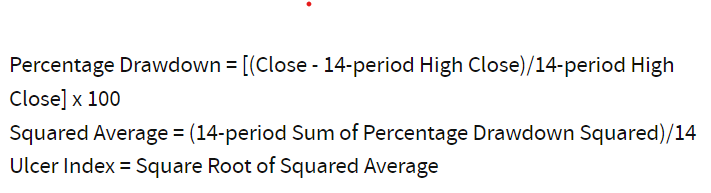

In [ ]:
n = 14
df[str(n)+'-period Max Close'] = df['Adj Close'].rolling(n).max()
df['Percent_Drawdown'] = 100* (df['Adj Close'] - df[str(n)+'-period Max Close'])/df[str(n)+'-period Max Close']
df['Percent_Drawdown_Squared'] = df['Percent_Drawdown'] ** 2
df['Squared_Average'] = df['Percent_Drawdown_Squared'].rolling(n).sum()/14
df['Ulcer_Index'] = df['Squared_Average'].pow(0.5)
df = df.drop([str(n)+'-period Max Close','Percent_Drawdown','Percent_Drawdown_Squared','Squared_Average'],axis=1)

In [ ]:
df

,Open,High,Low,Close,Adj Close,Volume,Supertrend,Final Lowerband,Final Upperband,Ulcer_Index
Date,,,,,,,,,,
2017-12-21,10473.950195,10473.950195,10426.900391,10440.299805,10440.299805,151900,True,NaN,NaN,NaN
2017-12-22,10457.299805,10501.099609,10448.250000,10493.000000,10493.000000,138800,True,NaN,NaN,NaN
2017-12-26,10512.299805,10545.450195,10477.950195,10531.500000,10531.500000,155600,True,NaN,NaN,NaN
2017-12-27,10531.049805,10552.400391,10469.250000,10490.750000,10490.750000,165200,True,NaN,NaN,NaN
2017-12-28,10498.200195,10534.549805,10460.450195,10477.900391,10477.900391,272900,True,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-12-13,18524.400391,18617.250000,18490.199219,18608.000000,18608.000000,187600,True,18342.715438,NaN,0.899196
2022-12-14,18671.250000,18696.099609,18632.900391,18660.300781,18660.300781,208000,True,18342.715438,NaN,0.924828
2022-12-15,18614.400391,18652.900391,18387.699219,18414.900391,18414.900391,183100,True,18342.715438,NaN,1.083681


In [ ]:
dfc = df.copy()
dfc['VolumePositive'] = dfc['Open'] < dfc['Adj Close']
#dfc = dfc.dropna()
dfc = dfc.reset_index()
dfc['Date'] = mdates.date2num(dfc['Date'].tolist())

# Subplot :- Price and Ulcer

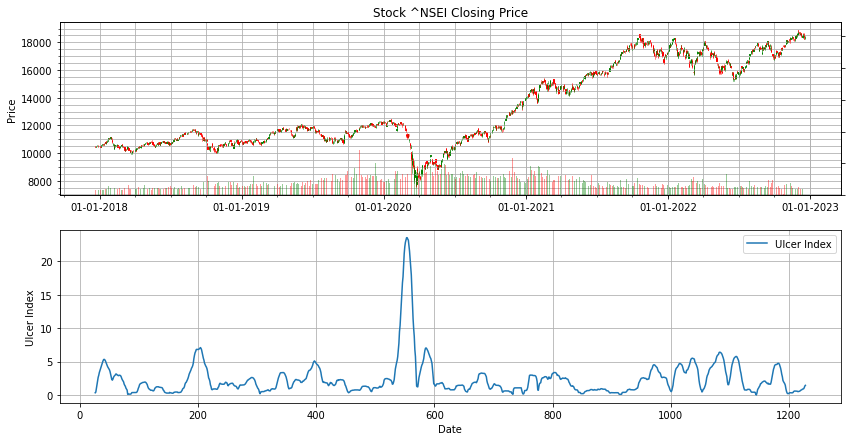

In [ ]:
fig = plt.figure(figsize=(14,7))
ax1 = plt.subplot(2, 1, 1)
candlestick_ohlc(ax1,dfc.values, width=0.5, colorup='g', colordown='r', alpha=1.0)
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.grid(True, which='both')
ax1.minorticks_on()
ax1v = ax1.twinx()
colors = dfc.VolumePositive.map({True: 'g', False: 'r'})
ax1v.bar(dfc.Date, dfc['Volume'], color=colors, alpha=0.4)
ax1v.axes.yaxis.set_ticklabels([])
ax1v.set_ylim(0, 3*dfc.Volume.max())
ax1.set_title('Stock '+ symbol +' Closing Price')
ax1.set_ylabel('Price')

ax2 = plt.subplot(2, 1, 2)
ax2.plot(dfc['Ulcer_Index'], label='Ulcer Index')
ax2.grid()
ax2.legend(loc='best')
ax2.set_ylabel('Ulcer Index')
ax2.set_xlabel('Date')
plt.show()

# BackTest and Strategy

In spite of the fact that Ulcer List tells us approximately the drawback dangers, but here we have concocted a strategy to exchange utilizing the ulcer record signals. As the flag crosses 5 from underneath, we start a purchase on the off chance that we are not in position at that time. So also, we get a sell flag as before long as the ulcer flag crosses 2 from underneath.

In [ ]:
def backtest_ulcer(df, investment):
    ulcer = df['Ulcer_Index']
    close = df['Close']
    
    # initial condition
    in_position = False
    equity = investment
    commission = 5
    share = 0
    entry = []
    exit = []
    
    for i in range(2, len(df)):
        # if not in position & price is on uptrend -> buy
        if not in_position and ulcer[i]>=5 and ulcer[i-1]<5:
            share = math.floor(equity / close[i] / 100) * 100
            equity -= share * close[i]
            entry.append((i, close[i]))
            in_position = True
            print(f'Buy {share} shares at {round(close[i],2)} on {df.index[i].strftime("%Y/%m/%d")}')
        # if in position & price is not on uptrend -> sell
        elif in_position and ulcer[i]>=2 and ulcer[i-1]<2:
            equity += share * close[i] - commission
            exit.append((i, close[i]))
            in_position = False
            print(f'Sell at {round(close[i],2)} on {df.index[i].strftime("%Y/%m/%d")}')
    # if still in position -> sell all share 
    if in_position:
        equity += share * close[i] - commission
    
    earning = equity - investment
    roi = round(earning/investment*100,2)
    print(f'Earning from investing Rs.1cr is Rs.{round(earning,2)} (ROI = {roi}%)')
    return entry, exit, equity


# Returns (Ulcer Index) 😃

In [ ]:
entry, exit, roi = backtest_ulcer(df, 10000000)

Buy 900 shares at 10360.4 on 2018/02/20
Sell at 11377.75 on 2018/09/17
Buy 1000 shares at 10316.45 on 2018/10/05
Sell at 10640.95 on 2019/02/18
Buy 1000 shares at 10855.5 on 2019/08/07
Sell at 11126.4 on 2019/10/07
Buy 1000 shares at 11269.0 on 2020/03/05
Sell at 9205.6 on 2020/05/05
Buy 1000 shares at 9142.75 on 2020/05/14
Sell at 11153.65 on 2020/09/22
Buy 700 shares at 16013.45 on 2022/03/08
Sell at 17173.65 on 2022/04/18
Buy 700 shares at 16167.1 on 2022/05/11
Sell at 15732.1 on 2022/06/14
Buy 700 shares at 15413.3 on 2022/06/22
Sell at 17655.6 on 2022/09/06
Earning from investing Rs.1cr is Rs.3535725.04 (ROI = 35.36%)
